<a href="https://colab.research.google.com/github/Ramla24/End-to-End-Text-Summarization-and-Analysis-System./blob/main/Fine_tuning_BART_for_Abstractive_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-Tuning BART for News Summarization
This notebook demonstrates how we fine-tuned the BART model using the MultiNews dataset, applying LoRA for parameter-efficient training.

In [ ]:
!pip install datasets rouge_score peft

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=48b1b80e78615dde9b6b3e428d7f6afa9058f852798f03d0aec689b9f1618ffe
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import pandas as pd
from datasets import Dataset
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import matplotlib.pyplot as plt
from transformers import DataCollatorForSeq2Seq
from rouge_score import rouge_scorer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/AbstractiveSummarization.csv"

In [ ]:
import re
from bs4 import BeautifulSoup

# Function to clean text with the specific cleaning steps you mentioned
def clean_text(text):
    # 1. HTML Removal
    text = BeautifulSoup(text, "html.parser").get_text()

    # 2. Special Character and Digit Removal
    text = re.sub(r"[^a-zA-Z0-9.!$?\” \“'\s]", '', text)

    # 3. Lowercasing
     #text = text.lower()

    # 4. Whitespace Removal
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
from transformers import BartTokenizer

# Initialize the BART tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Input sentence in original case
original_text = "Hello, how are you?"

# Input sentence in lowercase
lowercase_text = original_text.lower()

# Tokenize both versions
tokens_original = tokenizer.tokenize(original_text)
tokens_lowercase = tokenizer.tokenize(lowercase_text)

# Print the results
print("Original case tokens:", tokens_original)
print("Lowercase tokens:", tokens_lowercase)

# Check if they are the same or different
if tokens_original == tokens_lowercase:
    print("The tokenizer is NOT case-sensitive.")
else:
    print("The tokenizer is case-sensitive.")



In [ ]:
tokens = tokenizer.tokenize(text)
tokens

In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df.shape

(5622, 2)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df.dropna(subset=['document'])

In [ ]:
df.isna().sum()

,0
document,0
summary,0


In [ ]:
df.shape

(5621, 2)

In [ ]:
df_sample = df[:100]

In [ ]:
df_sample.shape

In [ ]:
df_sample['content'][0]

In [ ]:
cleaned_texts = [clean_text(text) for text in df_sample['content']]

In [ ]:
cleaned_texts[1]

In [ ]:
df['cleaned_text'] = df['document'].apply(clean_text)
df['cleaned_summary'] = df['summary'].apply(clean_text)

In [ ]:
df['cleaned_text'][1]

'after the bullet shells get counted the blood dries and the votive candles burn out people peer down from windows and see crime scenes gone cold a band of yellow police tape blowing in the breeze. the south bronx just across the harlem river from manhattan and once shorthand for urban dysfunction still suffers violence at levels long ago slashed in many other parts of new york city. and yet the citys efforts to fight it remain splintered underfunded and burdened by scandal. in the 40th precinct at the southern tip of the bronx as in other poor minority neighborhoods across the country people long hounded for infractions are crying out for more protection against grievous injury or death. by september four of every five shootings in the precinct this year were unsolved. out of the citys 77 precincts the 40th has the highest murder rate but the fewest detectives per violent crime reflecting disparities in staffing that hit hardest in some neighborhoods outside manhattan according to a n

In [ ]:
def count_words(text):
    words = text.split()  # Split the text into words based on spaces
    return len(words)

# Apply the word count function to the text column
df['word_count'] = df['document'].apply(count_words)

# Sort the dataframe by word count to find the texts with the highest word count
df_sorted = df.sort_values(by='word_count', ascending=False)


# If you want to get the highest word count specifically:
max_word_count = df['word_count'].max()
print(f'The highest word count is: {max_word_count}')

The highest word count is: 123120


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


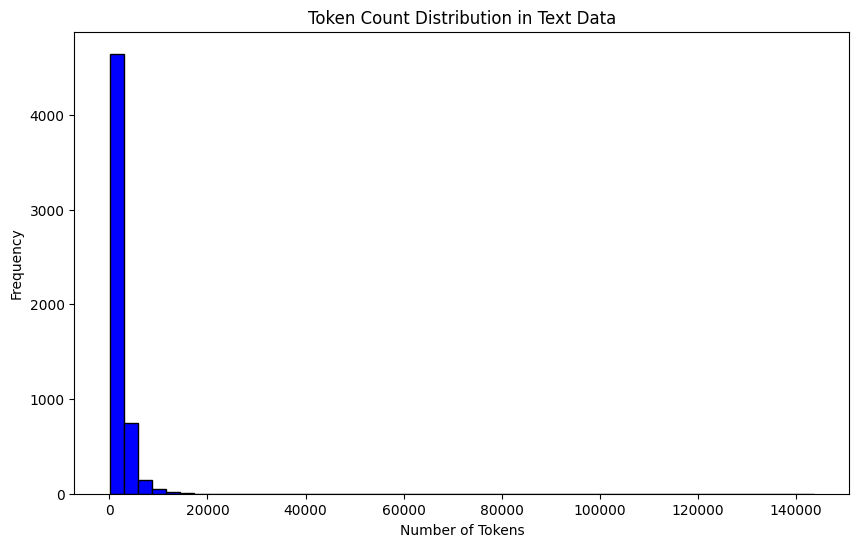

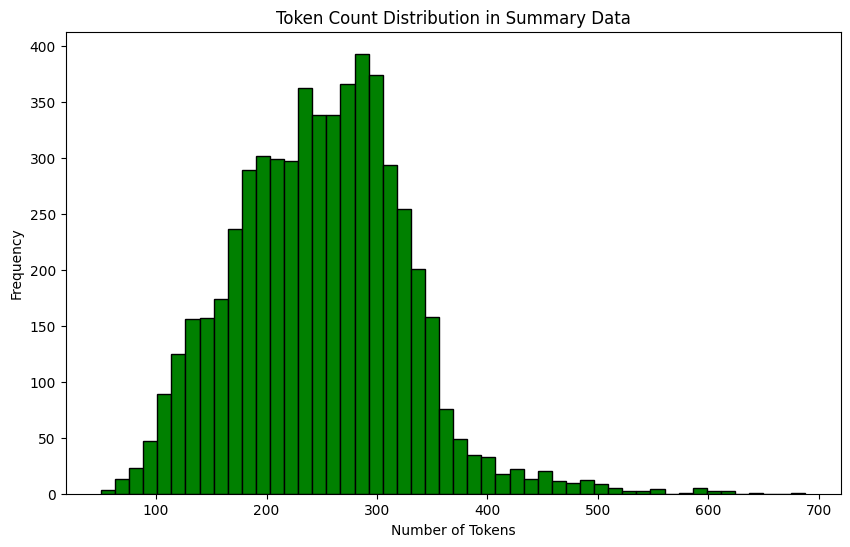

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-cnn')

# Function to count tokens in a text
def count_tokens(text):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

# Apply token counting to each row in your dataset
df['token_count'] = df['cleaned_text'].apply(count_tokens)

# Plotting the number of tokens
plt.figure(figsize=(10,6))
plt.hist(df['token_count'], bins=50, color='blue', edgecolor='black')
plt.title('Token Count Distribution in Text Data')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()


df['summary_token_count'] = df['cleaned_summary'].apply(count_tokens)

# Plotting the number of tokens
plt.figure(figsize=(10,6))
plt.hist(df['summary_token_count'], bins=50, color='green', edgecolor='black')
plt.title('Token Count Distribution in Summary Data')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

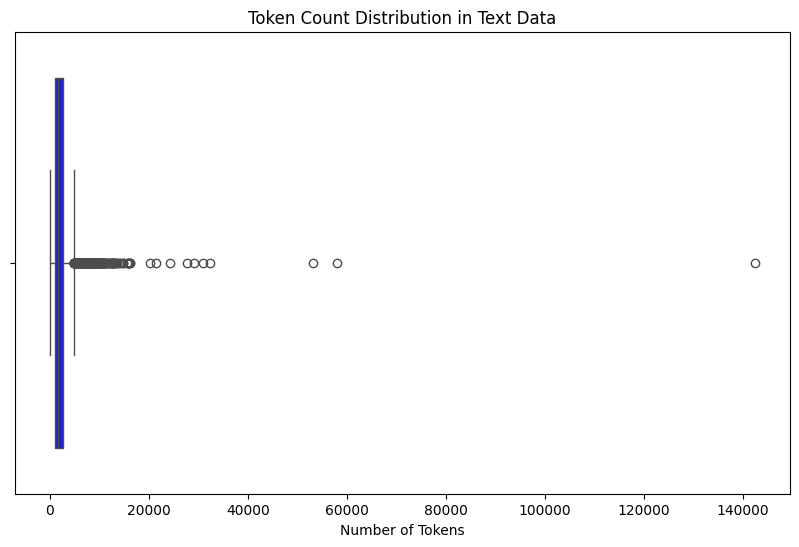

In [ ]:
import seaborn as sns

# Box plot for token count distribution in text data
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['token_count'], color='blue')
plt.title('Token Count Distribution in Text Data')
plt.xlabel('Number of Tokens')
plt.show()


In [ ]:
max_token_count = df['token_count'].max()
print(f'The highest word count is: {max_token_count}')

In [ ]:
# Count the number of texts with more than 5000 tokens
texts_with_more_than_5000_tokens = df[df['token_count'] <= 3000]

# Get the number of such texts
number_of_texts = texts_with_more_than_5000_tokens.shape[0]

print(f"Number of texts with more than 5000 tokens: {number_of_texts}")

Number of texts with more than 5000 tokens: 4699


In [ ]:
df = df[df['token_count'] <= 3000]

In [ ]:
df.shape

(4699, 7)

In [ ]:
max_token_limit = tokenizer.model_max_length
max_token_limit #maximum number of tokens that the model can accept as input.

1000000000000000019884624838656

In [ ]:
texts = df['cleaned_text'].tolist()
summaries = df['cleaned_summary'].tolist()

In [ ]:
len(text)

1714

In [ ]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-cnn')

# Define the max token length for the model and overlap size
max_token_length = 1024  # Modify based on your model's token limit
overlap_size = 256  # Number of tokens to overlap

# Function to chunk text with overlap
def chunk_text_with_overlap(text, tokenizer, max_length, overlap):
    tokens = tokenizer.tokenize(text)
    chunks = []

    # Create the first chunk
    first_chunk = tokens[:max_length]  # Get the first chunk
    chunk_text = tokenizer.convert_tokens_to_string(first_chunk)
    chunks.append(chunk_text)

    # If the first chunk is less than max_length, we don't need more chunks
    if len(first_chunk) < max_length:
        return chunks

    # Continue chunking with overlap for the rest of the text
    for i in range(max_length - overlap, len(tokens), max_length - overlap):
        chunk = tokens[i:i + max_length]
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        chunks.append(chunk_text)

    return chunks

# Create chunks for each text, and pair each chunk with the full summary
input_chunks = []
output_summaries = []

# for text, summary in zip(texts, summaries):
#     text_chunks = chunk_text_with_overlap(text, tokenizer, max_token_length, overlap_size)

#     # Pair each chunk with the full summary
#     for chunk in text_chunks:
#         input_chunks.append(chunk)
#         output_summaries.append(summary)





/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from datasets import Dataset

# Tokenize inputs and summaries
def tokenize_function(examples):
    inputs = tokenizer(examples['text'], max_length=max_token_length, padding='max_length', truncation=True, return_tensors="pt")
    targets = tokenizer(examples['summary'], max_length=max_token_length, padding='max_length', truncation=True, return_tensors="pt")
    return {
        'input_ids': inputs['input_ids'].squeeze(),
        'attention_mask': inputs['attention_mask'].squeeze(),
        'labels': targets['input_ids'].squeeze()
    }

# Prepare your dataset with text-summary pairs
data_dict = {'text': input_chunks, 'summary': output_summaries}
dataset = Dataset.from_dict(data_dict)

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Split into training and evaluation datasets
train_dataset = tokenized_dataset.train_test_split(test_size=0.2)['train']
eval_dataset = tokenized_dataset.train_test_split(test_size=0.2)['test']


Map:   0%|          | 0/10331 [00:00<?, ? examples/s]

In [ ]:
df.shape

(4699, 6)

In [ ]:
train_dataset

Dataset({
    features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 8264
})

In [ ]:
from transformers import BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from peft import get_peft_model, LoraConfig

# Load the model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")


# Configure LoRA for PEFT
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["self_attn.k_proj", "self_attn.v_proj"],  # Focus on attention layers
    lora_dropout=0.1,
    bias="none"
)

# Wrap the model with PEFT (LoRA)
peft_model = get_peft_model(model, peft_config)

# Freeze all layers in the base model
for param in model.parameters():
    param.requires_grad = False

# Ensure only LoRA parameters are trainable
for name, param in peft_model.named_parameters():
    if "lora" in name:
        param.requires_grad = True

# Print trainable parameters to confirm
peft_model.print_trainable_parameters()


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

trainable params: 786,432 || all params: 407,076,864 || trainable%: 0.1932


In [ ]:
device = torch.device("cpu")
peft_model.to(device)

In [ ]:
print(model.device)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Metric
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode IDs to text
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Calculate ROUGE scores
    rouge_scores = []
    for ref, pred in zip(labels_str, pred_str):
        score = rouge_scorer.score(ref, pred)
        rouge_scores.append(score)

    # Compute average ROUGE scores
    avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

    return {"rouge1": avg_rouge1, "rougeL": avg_rougeL}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='/content/drive/MyDrive/results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=1000,
    num_train_epochs=3,
    fp16=True,
    remove_unused_columns=False

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Seq2SeqTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics



)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving results.zip to results.zip


In [ ]:
!unzip results.zip


Archive:  results.zip
   creating: results/
   creating: results/checkpoint-3000/
  inflating: results/checkpoint-3000/adapter_model.safetensors  
  inflating: results/checkpoint-3000/optimizer.pt  
  inflating: results/checkpoint-3000/trainer_state.json  
  inflating: results/checkpoint-3000/training_args.bin  
  inflating: results/checkpoint-3000/rng_state.pth  
  inflating: results/checkpoint-3000/scheduler.pt  
  inflating: results/checkpoint-3000/adapter_config.json  
  inflating: results/checkpoint-3000/README.md  
   creating: results/checkpoint-4000/
  inflating: results/checkpoint-4000/adapter_model.safetensors  
  inflating: results/checkpoint-4000/optimizer.pt  
  inflating: results/checkpoint-4000/trainer_state.json  
  inflating: results/checkpoint-4000/training_args.bin  
  inflating: results/checkpoint-4000/rng_state.pth  
  inflating: results/checkpoint-4000/scheduler.pt  
  inflating: results/checkpoint-4000/adapter_config.json  
  inflating: results/checkpoint-4000/RE

In [ ]:
trainer.train(resume_from_checkpoint='./results/checkpoint-8000')


/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Epoch,Training Loss,Validation Loss,Rouge1,Rougel
2,1.664500,1.347042,0.369468,0.189288


KeyboardInterrupt: 

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rougel
1,1.675200,1.352511,0.361487,0.186785


KeyboardInterrupt: 

In [ ]:
!zip -r results.zip ./results


  adding: results/ (stored 0%)
  adding: results/checkpoint-3000/ (stored 0%)
  adding: results/checkpoint-3000/adapter_model.safetensors (deflated 7%)
  adding: results/checkpoint-3000/optimizer.pt (deflated 8%)
  adding: results/checkpoint-3000/trainer_state.json (deflated 74%)
  adding: results/checkpoint-3000/training_args.bin (deflated 52%)
  adding: results/checkpoint-3000/rng_state.pth (deflated 25%)
  adding: results/checkpoint-3000/scheduler.pt (deflated 55%)
  adding: results/checkpoint-3000/adapter_config.json (deflated 52%)
  adding: results/checkpoint-3000/README.md (deflated 66%)
  adding: results/checkpoint-4000/ (stored 0%)
  adding: results/checkpoint-4000/adapter_model.safetensors (deflated 7%)
  adding: results/checkpoint-4000/optimizer.pt (deflated 8%)
  adding: results/checkpoint-4000/trainer_state.json (deflated 76%)
  adding: results/checkpoint-4000/training_args.bin (deflated 52%)
  adding: results/checkpoint-4000/rng_state.pth (deflated 25%)
  adding: results/c

In [ ]:
from google.colab import files
files.download('results.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
peft_model.save_pretrained("./extractivemodel")
tokenizer.save_pretrained("./extractivemodel")

('./extractivemodel/tokenizer_config.json',
 './extractivemodel/special_tokens_map.json',
 './extractivemodel/vocab.json',
 './extractivemodel/merges.txt',
 './extractivemodel/added_tokens.json',
 './extractivemodel/tokenizer.json')

In [ ]:
peft_model.save_pretrained("/content/drive/MyDrive/peftabstractivemodel")
tokenizer.save_pretrained("/content/drive/MyDrive/abstractivetokenizer")
model.save_pretrained("/content/drive/MyDrive/baseabstractivemodel")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/abstractivetokenizer")
model = AutoModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/peftabstractivemodel")

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
def generate_summary_for_long_text(text, model, tokenizer,length_type='medium', max_length=1024, overlap=256):
    # Chunk the input text
    cleantext = clean_text(text)

    text_chunks = chunk_text_with_overlap(cleantext, tokenizer, max_length, overlap)



    generated_summaries = []



    for chunk in text_chunks:
        # Tokenize the chunk for the model

        inputs = tokenizer(chunk, return_tensors="pt", truncation=True, max_length=max_length)
        input_ids = inputs["input_ids"]
        input_length = inputs['input_ids'].shape[-1]

        if length_type == 'small':
          s_max_length = int(input_length * 0.2)  # Small summary (20% of input length)
        elif length_type == 'medium':
          s_max_length = int(input_length * 0.4)  # Medium summary (50% of input length)
        elif length_type == 'large':
          s_max_length = int(input_length * 0.6)

        s_max_length = min(s_max_length, 1024)

        # Generate the summary for the chunk
        print(s_max_length)
        summary_ids = model.generate(input_ids, num_beams=2,temperature =0.9,length_penalty=2.0, early_stopping=True)
        summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        generated_summaries.append(summary_text)

    # Combine the generated summaries for each chunk
    final_summary = " ".join(generated_summaries)

    return final_summary


In [ ]:

input_text = """The Department of Meteorology says the atmospheric conditions are changing in favour of afternoon thundershowers in most parts of Sri Lanka for the next few days starting tomorrow (27).

Accordingly, several spells of showers will occur in the Western, Sabaragamuwa and North-western provinces and Kandy, Nuwara-Eliya, Galle and Matara districts. Showers or thundershowers may occur at several places in the Eastern and Uva provinces and Mullaitivu district during the evening or night.

Strong winds of about 40-45 kmph can be expected at times over the western slopes of the central hills and in Northern, North-central and North-western provinces and Matale, Hambantota and Monaragala districts.

Meanwhile, showers may occur at several places in the sea areas off the coast extending from Chilaw to Hambantota via Galle.

Winds will be Westerly or South-westerly in direction and wind speed will be 30-40 kmph. Wind speed can increase up to 60 kmph at times in the sea areas off the coasts extending from Matara to Pottuvil via Hambantota. Wind speed can increase up to 50 kmph at times in the sea areas off the coasts extending from Kankasanthurai to Puttalam via Mannar.

Winds will be Westerly or South-westerly in direction and wind speed will be (30-40) kmph. Wind speed can increase up to 60 kmph at times in the sea areas off the coasts extending from Matara to Pottuvil via Hambantota. Wind speed can increase up to 50 kmph at times in the sea areas off the coasts extending from Kankasanthurai to Puttalam via Mannar. ”"""



In [ ]:
extsmall = generate_summary_for_long_text(input_text,model,tokenizer, length_type='small')

69


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
extsmall

'The Department of Meteorology says the atmospheric conditions are changing to favor afternoon thundershowers in most parts of Sri Lanka for the next few days starting tomorrow 27. Showers or thundershower may occur at several places in the Eastern and Uva provinces and Mullaitivu district during the evening or night. Strong'

In [ ]:
from transformers import pipeline

# Load the summarization pipeline with the LED model
summarizer = pipeline("summarization", model="facebook/bart-base", tokenizer="facebook/bart-base")

# Your input document (can be a long article or news)


# Generate summary
summary = summarizer(input_text, max_length=100, do_sample=False)

# Output the summary
print("Generated Summary:", summary[0]['summary_text'])


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Generated Summary: The Department of Meteorology says the atmospheric conditions are changing in favour of afternoon thundershowers in most parts of Sri Lanka for the next few days starting tomorrow (27).“Accordingly, several spells of showers will occur in the Western, Sabaragamuwa and North-western provinces and Kandy, Nuwara-Eliya, Galle and Matara districts. Showers or thunderhowers may occur at several places in the Eastern and Uva


In [ ]:
extsmall

'the department of meteorology says the atmospheric conditions are changing in favour of afternoon thundershowers in most parts of sri lanka for the next few days starting tomorrow 27. wind speed can increase up to 50 kmph at times in the sea areas off the coasts extending from kankasanthurai to puttalam'

In [ ]:
smallsum =generate_summary_for_long_text(input_text,model,tokenizer, length_type='small')

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
len(smallsum)

345

In [ ]:
smallsum

'the department of meteorology says the atmospheric conditions are changing in favour of afternoon thundershowers in most parts of sri lanka for the next few days starting tomorrow 27. strong winds of about 4045 kmph can be expected at times over the western slopes of the central hills and in northern northcentral and northwestern provinces and'

In [ ]:
largesum =generate_summary_for_long_text(input_text,model,tokenizer, length_type='large')

In [ ]:
largesum

'the department of meteorology says the atmospheric conditions are changing in favour of afternoon thundershowers in most parts of sri lanka for the next few days starting tomorrow 27. strong winds of about 4045 kmph can be expected at times over the western slopes of the central hills and in northern northcentral and northwestern provinces and matale hambantota and monaragala districts. meanwhile showers may occur at several places in the sea areas off the coast extending from chilaw to hambantoto via galle. winds will be westerly or southwesterly in direction and wind speed will be 3040 kmph. wind speed can increase up to 50 kmph at times in the seas off the coasts extending from kankasanthurai to puttalam via mannar. showers or thundersshowers may occur in the eastern and uva provinces and mullaitivu district during the evening or night. wind power can increase to 60 kmph in some places. ”'

In [ ]:
len(largesum)

904

In [ ]:
len(sum)

807

In [ ]:
sum

'the department of meteorology says the atmospheric conditions are changing in favour of afternoon thundershowers in most parts of sri lanka for the next few days starting tomorrow 27. strong winds of about 4045 kmph can be expected at times over the western slopes of the central hills and in northern northcentral and northwestern provinces and matale hambantota and monaragala districts. meanwhile showers may occur at several places in the sea areas off the coast extending from chilaw to hambantoto via galle. winds will be westerly or southwesterly in direction and wind speed will be 3040 kmph. wind speed can increase up to 60 kmph at times in the seas off the coasts extending from matara to pottuvil via hambantotta.the department says the atmosphere is changing in favor of afternoon thunderstorms'

In [ ]:
input_text

'The Department of Meteorology says the atmospheric conditions are changing in favour of afternoon thundershowers in most parts of Sri Lanka for the next few days starting tomorrow (27). \n\nAccordingly, several spells of showers will occur in the Western, Sabaragamuwa and North-western provinces and Kandy, Nuwara-Eliya, Galle and Matara districts. Showers or thundershowers may occur at several places in the Eastern and Uva provinces and Mullaitivu district during the evening or night. \n\nStrong winds of about 40-45 kmph can be expected at times over the western slopes of the central hills and in Northern, North-central and North-western provinces and Matale, Hambantota and Monaragala districts.\n\nMeanwhile, showers may occur at several places in the sea areas off the coast extending from Chilaw to Hambantota via Galle.\n\nWinds will be Westerly or South-westerly in direction and wind speed will be 30-40 kmph. Wind speed can increase up to 60 kmph at times in the sea areas off the co

Evaluation

In [ ]:
df.shape

(5621, 7)

In [ ]:
df.columns

Index(['document', 'summary', 'cleaned_text', 'cleaned_summary', 'word_count',
       'token_count', 'summary_token_count'],
      dtype='object')

In [ ]:
ev_df = df.head(50)

In [ ]:
ev_df.shape

(50, 7)